# Dynamic Entry Analysis

The objective of this analysis is to look at how we can monitor the augmentation of data on roads in OSM. The idea being to set expectations on how road and mobility data is going to evolve in the time frame of the project. At shis stage, we are looking to explore the dynamics of data entry, and define a simple predictive model for future data evolution we should expect. 

## Data load and format

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline

The current data is with two main sources:
* Monthly length of roads documented in OSM since 2010, extracted by Yann. This data is stored by type of road, using tags in OSM.
* Size of OSM in 2017, 2018 and 2019 (date ?)
* Size of population at the same dates

All theses data are availabe for all African countries.

In [23]:
# Loading and formatting yearly aggregated data
data_densities = pd.read_csv("../data/output/osmdb_densities.csv")
data_densities = data_densities.rename(columns={"Unnamed: 0":"country"})
data_densities.country = data_densities.country.str.replace(" ","_")
data_densities=data_densities.drop("GR_2017_2019",axis = 1)

# Formatting to make analysis suited
data_densities = data_densities.set_index("country").stack().reset_index().rename(columns = {"level_1":"indicator",0:"value"})

# Extracting year and indicator type from names
# NOTE : For now taking year - 1 for matching with road data (ie, hypotesis = data is from january of the indicated year)
data_densities["year"] = (data_densities.indicator.str.split("_").apply(lambda x: x[-1]).astype(int) - 1).astype(str)
data_densities["data"] = data_densities.indicator.str.split("_").apply(lambda x: "_".join(x[:-1]))

print("DENSITY DATA EXAMPLE")
print(data_densities.sample(10))

# Loading road data (stored as one file by country)
road_data = pd.DataFrame()
for file in os.listdir("../data/output/roads_availability"):
    dat_country = pd.read_csv("../data/output/roads_availability/" + file)
    dat_country["country"] = file[:-4]
    road_data = road_data.append(dat_country)
    
road_data = road_data.rename(columns={'Unnamed: 0':"road_type"})

# Recoding types of road to lump garbage tags or composite ones as "unknown" 
# QUESTION: Any interest in disentangling unknown tags ?
road_data.loc[pd.isnull(road_data.road_type),"road_type"] = "unknown"
road_data["clean_type"] = road_data["road_type"]
unique_types = road_data.road_type.value_counts()[road_data.road_type.value_counts() < 10].index.tolist()
road_data.loc[road_data.road_type.isin(unique_types),"clean_type"] = "unknown"

# Formatting road data to make it more suited to data analysis 
road_data = road_data.set_index(["road_type","country","clean_type"]).stack().reset_index().rename(columns = {"level_3":"date",0:"n_km"})
road_data.date = pd.to_datetime(road_data.date)

print("ROAD DATA EXAMPLE")
print(road_data.sample(10))

DENSITY DATA EXAMPLE
                country     indicator   value  year     data
402         South_Sudan  DB_AREA_2017   55.99  2016  DB_AREA
405               Sudan       DB_2017   14.30  2016       DB
415           Swaziland       DB_2018   21.70  2017       DB
303          Mozambique  DB_AREA_2017  118.97  2016  DB_AREA
151             Eritrea  DB_AREA_2018   21.22  2017  DB_AREA
351  Senegal_and_Gambia       DB_2017   29.10  2016       DB
395        South_Africa  DB_AREA_2019  102.64  2018  DB_AREA
172               Ghana       DB_2018   19.50  2017       DB
397         South_Sudan       DB_2018   61.70  2017       DB
469            Zimbabwe       DB_2018  124.00  2017       DB
ROAD DATA EXAMPLE
            road_type                      country      clean_type       date  \
36188   living_street                      Namibia   living_street 2010-01-01   
37929     residential                      Liberia     residential 2014-10-01   
32909         footway                       Zam

## Data Description

### Basic descriptives

To be updated

### Data availability trends

We first consider the length of road available in OSM since 2010. The first graph shows a pretty consistent upward trend for most countries. DRC seems to have the longest documented road network, far before Kenya or Mozambique. We see a pattern of plateaux and surges in data entry linked to crises that are often the occasion for community engagement and mapathon, as indicated with the West African surges linked with the 2014 Ebola outbreak. In DRC, the late data entry surge since early 2018 could be linked with the Ebola outbreaks, but a more fine grained analysis on exact locations would give more indications.

#### Road network size

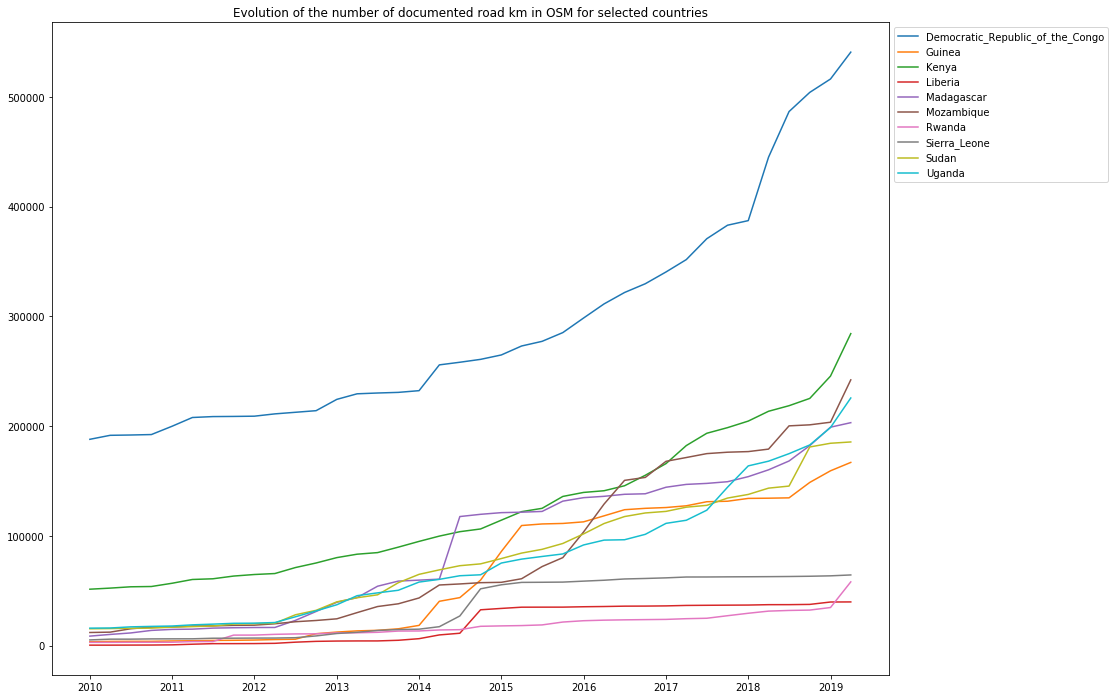

In [29]:
countries_of_interest = ["Guinea","Mozambique","Democratic_Republic_of_the_Congo","Sierra_Leone","Liberia","Sudan","Madagascar","Rwanda","Kenya","Uganda"]

plot_dat = road_data.groupby(["country","date"]).sum().reset_index()
plot_dat = plot_dat[plot_dat.country.isin(countries_of_interest)]
fig = plt.figure(figsize=[15,12])
for country in plot_dat.country.unique():
    plt.plot(plot_dat[plot_dat.country==country].date, plot_dat[plot_dat.country==country].n_km, label = country)
    plt.legend(bbox_to_anchor=[1,1])
    plt.title("Evolution of the number of documented road km in OSM for selected countries")

#### Data Tags diversity

A second way to look at the data entry is to look at the tag diversity for the roads. We see that for each data entry surge, there is a spike in "unknown" road types, probably linked with the intervention of low experience contributors. This diversity is later on corrected, as shown by the DRC spike in 2014. This evolution of data diversity may mean that there is a delay between the time when new road data is entered, and the time it will be usable for our purposes. 

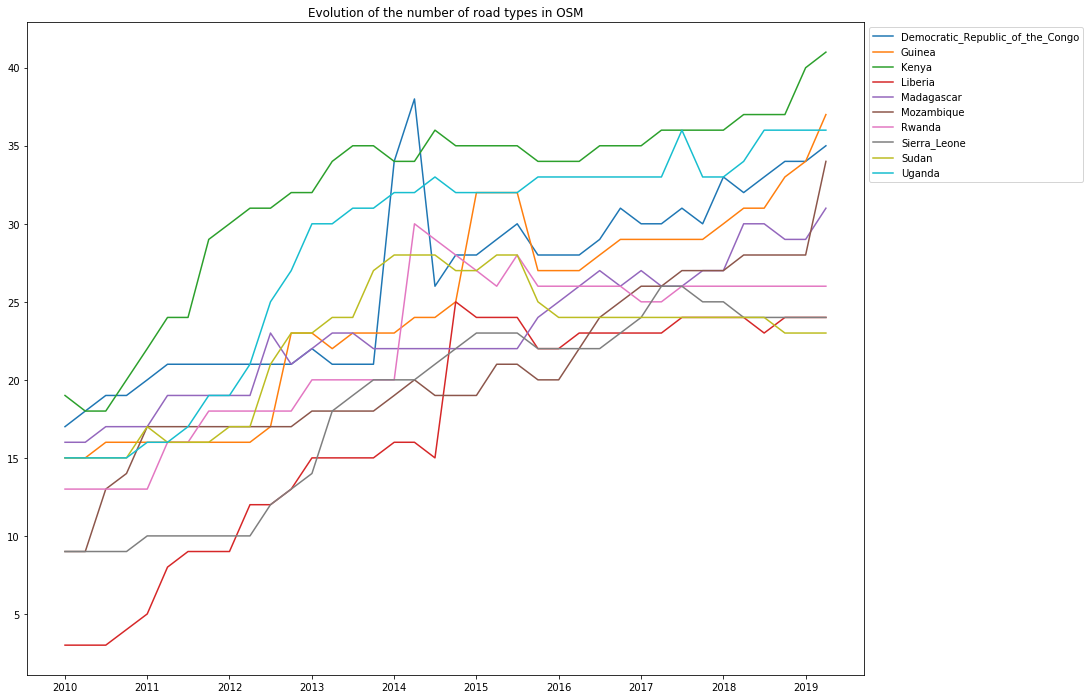

In [31]:
plot_dat = road_data.groupby(["country","date"]).road_type.nunique().reset_index()
plot_dat = plot_dat[plot_dat.country.isin(countries_of_interest)]
fig = plt.figure(figsize=[15,12])
for country in plot_dat.country.unique():
    plt.plot(plot_dat[plot_dat.country==country].date, plot_dat[plot_dat.country==country].road_type, label = country)
    plt.legend(bbox_to_anchor=[1,1])
    plt.title("Evolution of the number of road types in OSM")

#### Share of roads in overall Data

__<span style="color:red">NOTE : We should get a better metric here, rather size of road data / overall database size ? </span>__

Finally we want to look at the importance of roads data in the overall database. A model for OSM data creation would be that roads are first entered, and richer data on land occupation is later added. We test the hypothesis by looking at the ratio between the length of roads in OSM divided by the size of the database for the same country and same date.

We indeed see a downward trend for most countries, with the notable exception of Mozambique. Uganda offers an interesting example, where the ratio we measure has sunk in the past two years.

From this downward trend, it would be interesting to model an indicator an expected growth of road data to understand where and when we should expect to see additional data, or how to identify low road completeness zones.

In [10]:
# Only keeping december data points for roads data, and looking at DB size.
road_data_december = road_data[road_data.date.dt.month == 10].groupby(["country","date"]).n_km.sum().reset_index()
road_data_december["year"] = road_data_december.date.dt.year.astype(str)
data_m = data_densities[data_densities.data == "DB"].merge(road_data_december)

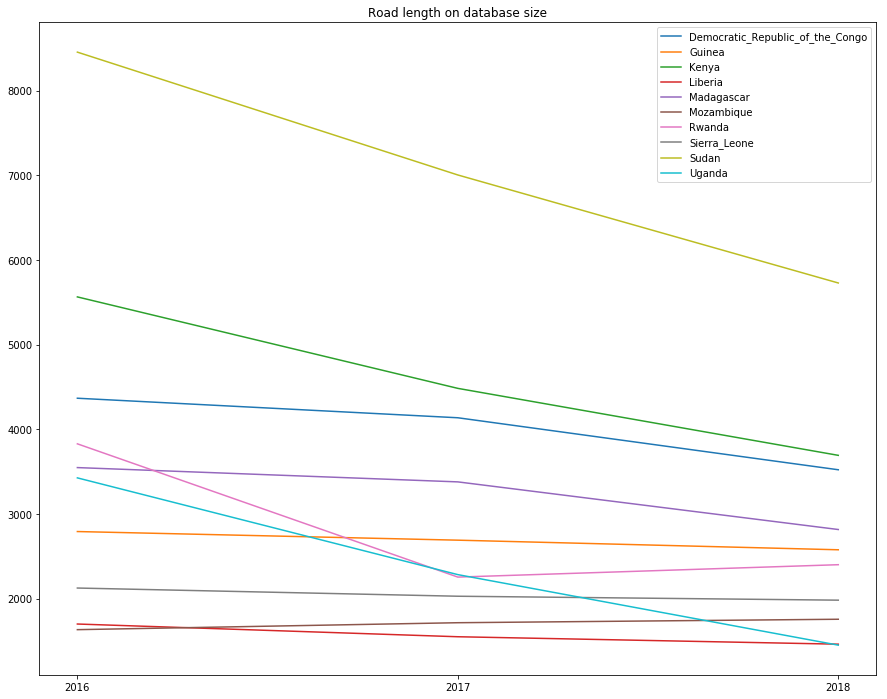

In [38]:
data_m = data_m[data_m.country.isin(countries_of_interest)]
fig = plt.figure(figsize=[15,12])
for country in data_m.country.unique():
    dat_plot = data_m[data_m.country == country]
    plt.plot(dat_plot.year, dat_plot.n_km / dat_plot.value, label = country)
    plt.legend(bbox_to_anchor=[1,1])
    plt.title("Road length on database size")